In [1]:
!pip install mxnet-cu100mkl

     |████████████████████████████████| 576.6MB 28kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


#LS GAN (Least Square Generative Adversarial Networks) - MXNet (From Scratch)

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

ctx = mx.gpu()

In [3]:
def transform(data):
    return data.reshape((784)).astype('float32')/255.0

train_mnist = gluon.data.vision.MNIST(train = True).transform_first(transform)

In [4]:
image, _ = train_mnist[1]
print(image.shape)

(784,)


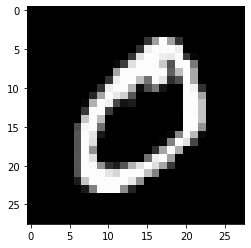

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy(), 'gray')
plt.show()

##Creating data loader for training and testing

In [0]:
batch_size = 64
training_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)

##Building the GAN model

Info gan is a next level approach to not just generate new data but to also learn the mutual relational represenations that the data contains, which could ultimately help us providing more control over data generated by generator.

The main goal of Info Gan is to have more control over generated data, unlike C Gan and AC Gan which only allow us to have control over the data generated based on the class __"only"__.

In every dataset there contains some examples that share a common representation, for instance in MNIST dataset all zeros are zeros.... as they have a very similar overall structure... a circle basically, similarly all ones are ones.... as all of em are like similar to a vertical straight line... and so on.

The example I have above are nothing but simply labels of our dataset. But there exists more latent relational codes that we can control to adjust the output of the generator. For example in case of MNIST, width of the number, height of the number, size of the number etc...

So in order to get these codes working, Info Gan proposes to have another deep learning model whose job is to simply predict the codes.

1. As we don't know the codes, we just randomly initialize them as __"random_label"__.
2. Pass them to the generator along with random noise to generate false.
3. Generator and discriminator simply play mini-max game as in vanilla gan.
4. Now that generated data is passes to the other new model... the classifier, to predict the codes let's say __"output_label"__.
5. And the classifier is optimized to minimize the __"-random_label * log(output_label)"__

In [0]:
# ===================== Discriminator Parameters ===========================
dw1 = nd.random.normal(0, 1, (784, 128), ctx = ctx) * 0.001
db1 = nd.random.normal(0, 1, 128, ctx = ctx) * 0.001

dw2 = nd.random.normal(0, 1, (128, 1), ctx = ctx) * 0.001
db2 = nd.random.normal(0, 1, 1, ctx = ctx) * 0.001
# ==========================================================================

# ======================= Generator Parameters =============================
gw1 = nd.random.normal(0, 1, (110, 128), ctx = ctx) * 0.001
gb1 = nd.random.normal(0, 1, 128, ctx = ctx) * 0.001

gw2 = nd.random.normal(0, 1, (128, 784), ctx = ctx) * 0.001
gb2 = nd.random.normal(0, 1, 784, ctx = ctx) * 0.001
# ==========================================================================

# ======================= Classifier Parameters =============================
cw1 = nd.random.normal(0, 1, (784, 128), ctx = ctx) * 0.001
cb1 = nd.random.normal(0, 1, 128, ctx = ctx) * 0.001

cw2 = nd.random.normal(0, 1, (128, 10), ctx = ctx) * 0.001
cb2 = nd.random.normal(0, 1, 10, ctx = ctx) * 0.001
# ==========================================================================

def leakyrelu(layer, alpha = 0.2):
    return nd.maximum(alpha * layer, layer)

def discriminator(x):
    layer1 = leakyrelu(nd.dot(x, dw1) + db1)
    predicted = nd.sigmoid(nd.dot(layer1, dw2) + db2)
    return predicted

def generator(z, y):
    inputs = nd.concat(z, y, dim = 1)
    layer1 = leakyrelu(nd.dot(inputs, gw1) + gb1)
    generated = nd.sigmoid(nd.dot(layer1, gw2) + gb2)
    return generated

def classifier(x):
    layer1 = leakyrelu(nd.dot(x, cw1) + cb1)
    generated = nd.sigmoid(nd.dot(layer1, cw2) + cb2)
    return generated

dparams = [dw1, db1, dw2, db2]
gparams = [gw1, gb1, gw2, gb2]
cparams = [cw1, cb1, cw2, cb2]

# as we this is an scratch implementation, so we are gonna implement the optimizer from scratch too

dsqrs = [] # for adam optimizer
dvs = [] # for adam optimizer

gsqrs = [] # for adam optimizer
gvs = [] # for adam optimizer

csqrs = [] # for adam optimizer
cvs = [] # for adam optimizer

for param in dparams:
    param.attach_grad()
    dsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    dvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    
for param in gparams:
    param.attach_grad()
    gsqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    gvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability

for param in cparams:
    param.attach_grad()
    csqrs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability
    cvs.append(param.zeros_like() + 1e-5) # adding 1e-5 for computational stability

In [0]:
def dloss(true, false):
    return -nd.mean(nd.log(true) + nd.log(1 - false))

def gloss(false):
    return -nd.mean(nd.log(false))

def closs(predictions, target):
    return -nd.mean(target * nd.log(predictions))

In [0]:
def adam(t, params, vs, sqrs, lr = 0.001):
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    for param, v, sqr in zip(params, vs, sqrs):
        grad = param.grad / batch_size

        v[:] = beta1 * v + (1. - beta1) * grad
        sqr[:] = beta2 * sqr + (1. - beta2) * nd.square(grad + 1e-8)

        v_bias_corr = v / (1. - beta1 ** t)
        sqr_bias_corr = sqr / (1. - beta2 ** t)

        update = lr * v_bias_corr / (nd.sqrt(sqr_bias_corr + 1e-8) + eps)
        param[:] = param - update
        
def sgd(params, lr = 0.001):
    for param in params:
        param[:] = param - lr * param.grad

Epoch: 0 | Generator Loss: 2.33951 | Discirminator Loss: 0.80518 | Classifier Loss: 0.06907


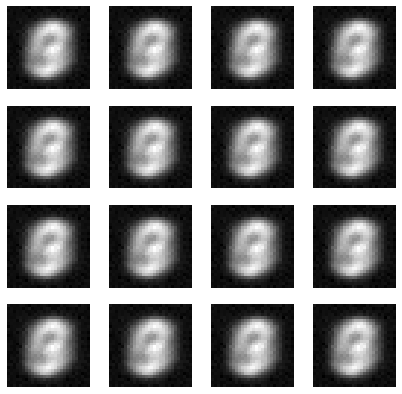

Epoch: 1 | Generator Loss: 5.10417 | Discirminator Loss: 0.06050 | Classifier Loss: 0.06752


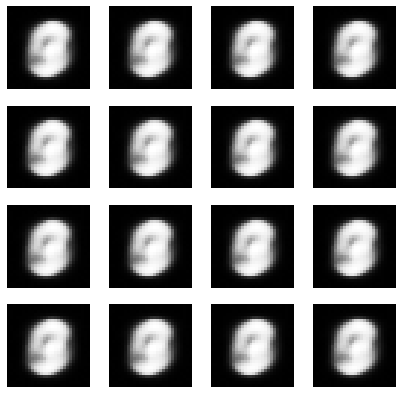

Epoch: 2 | Generator Loss: 2.19324 | Discirminator Loss: 0.75289 | Classifier Loss: 0.06300


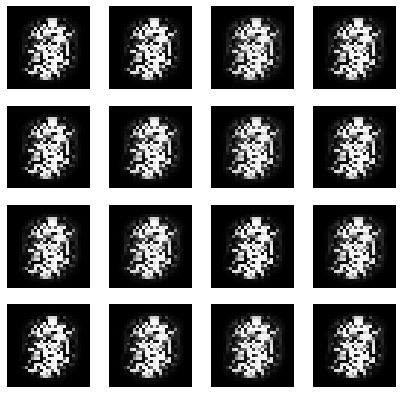

Epoch: 3 | Generator Loss: 1.91255 | Discirminator Loss: 0.71453 | Classifier Loss: 0.03085


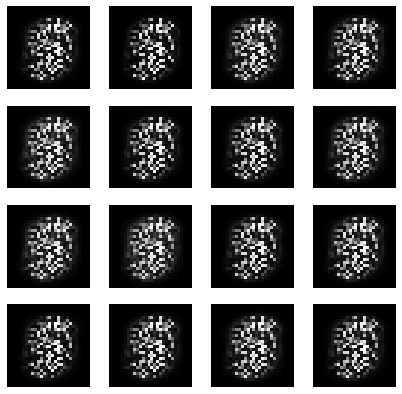

Epoch: 4 | Generator Loss: 2.16191 | Discirminator Loss: 0.68815 | Classifier Loss: 0.00473


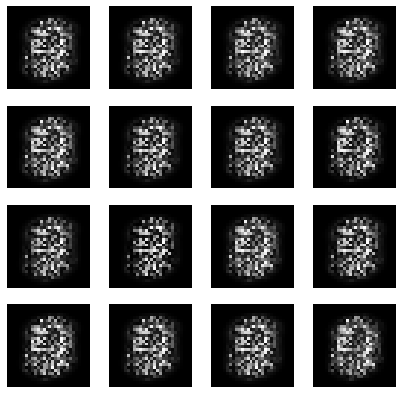

Epoch: 5 | Generator Loss: 2.58162 | Discirminator Loss: 0.58119 | Classifier Loss: 0.00147


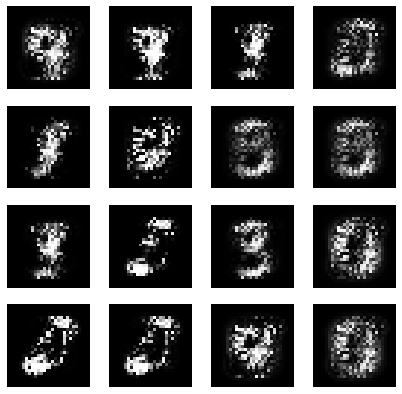

Epoch: 6 | Generator Loss: 2.23163 | Discirminator Loss: 0.89247 | Classifier Loss: 0.00039


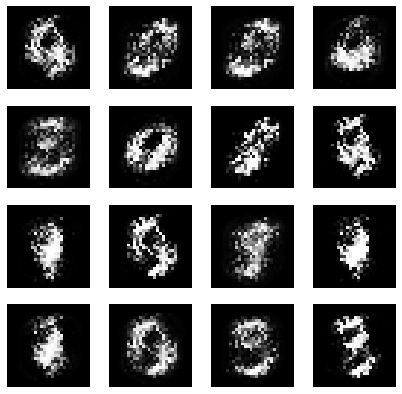

Epoch: 7 | Generator Loss: 2.17466 | Discirminator Loss: 0.99859 | Classifier Loss: 0.00018


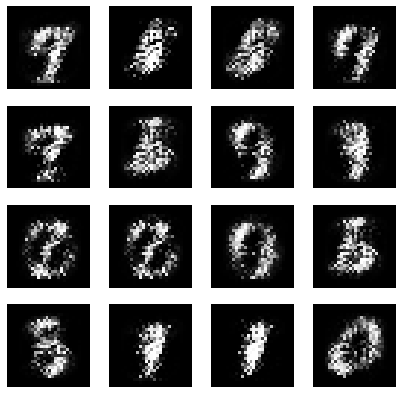

Epoch: 8 | Generator Loss: 1.82952 | Discirminator Loss: 1.22982 | Classifier Loss: 0.00021


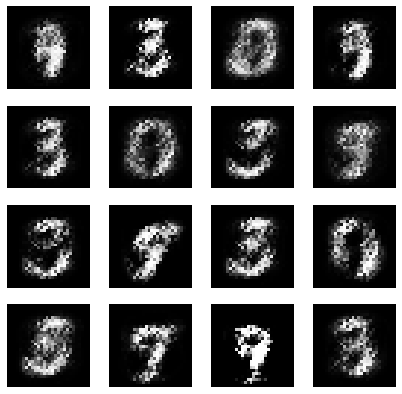

Epoch: 9 | Generator Loss: 1.66360 | Discirminator Loss: 1.43717 | Classifier Loss: 0.00016


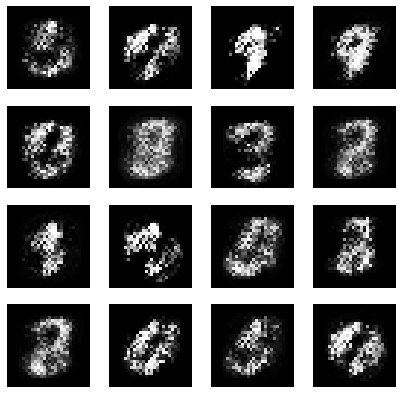

Epoch: 10 | Generator Loss: 1.69575 | Discirminator Loss: 1.41746 | Classifier Loss: 0.00007


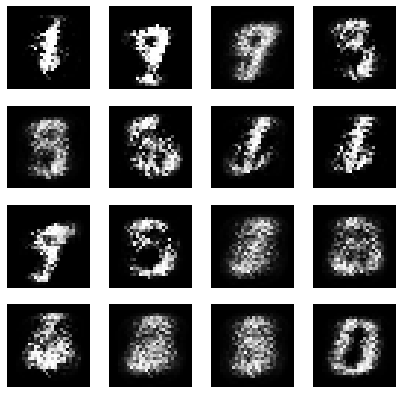

Epoch: 11 | Generator Loss: 1.47599 | Discirminator Loss: 1.52990 | Classifier Loss: 0.00006


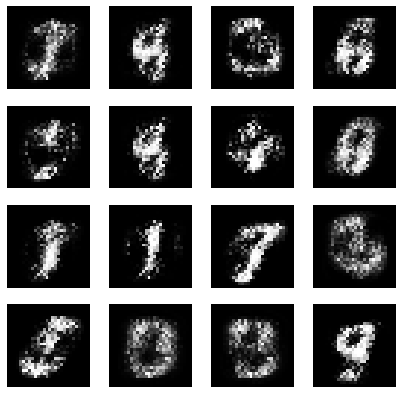

Epoch: 12 | Generator Loss: 1.23555 | Discirminator Loss: 1.57192 | Classifier Loss: 0.00007


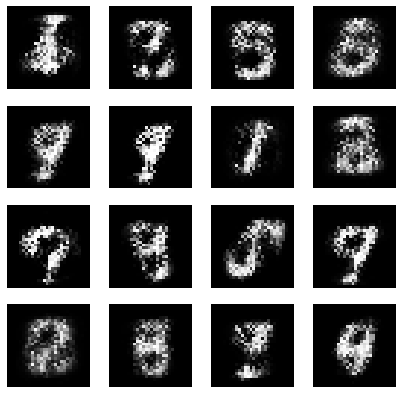

Epoch: 13 | Generator Loss: 1.17221 | Discirminator Loss: 1.51297 | Classifier Loss: 0.00006


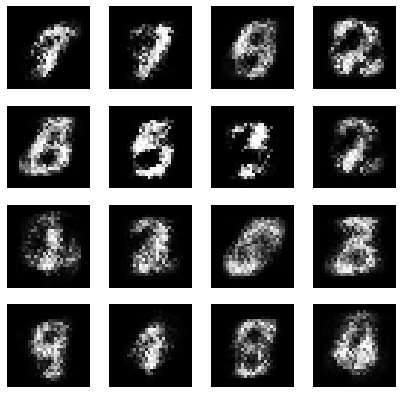

Epoch: 14 | Generator Loss: 1.06408 | Discirminator Loss: 1.59103 | Classifier Loss: 0.00004


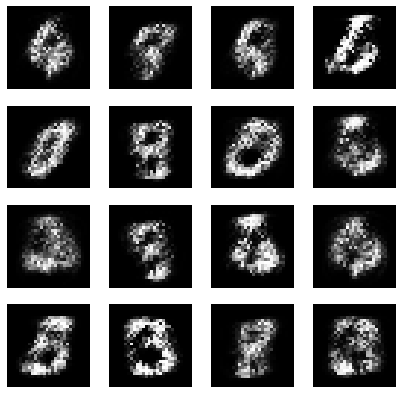

Epoch: 15 | Generator Loss: 0.97007 | Discirminator Loss: 1.48694 | Classifier Loss: 0.00006


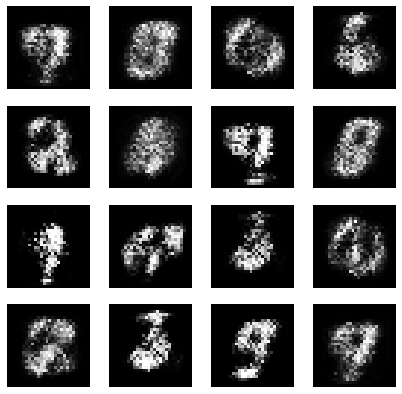

Epoch: 16 | Generator Loss: 1.00010 | Discirminator Loss: 1.47880 | Classifier Loss: 0.00004


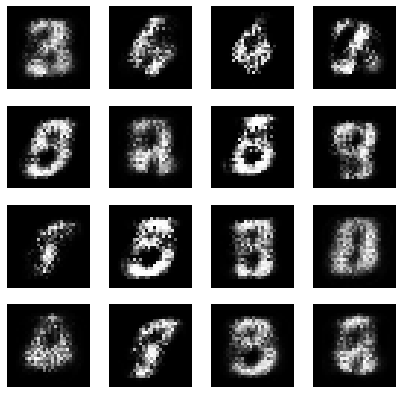

Epoch: 17 | Generator Loss: 0.94991 | Discirminator Loss: 1.48213 | Classifier Loss: 0.00004


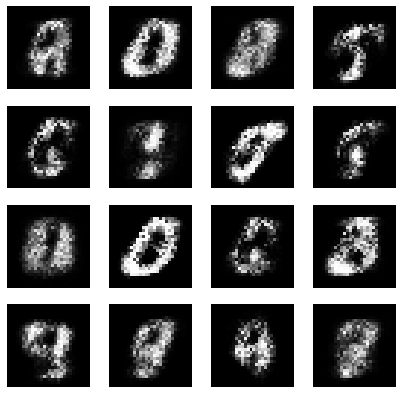

Epoch: 18 | Generator Loss: 0.91885 | Discirminator Loss: 1.41972 | Classifier Loss: 0.00004


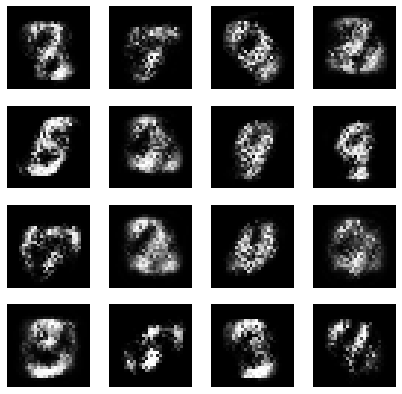

Epoch: 19 | Generator Loss: 0.94642 | Discirminator Loss: 1.37450 | Classifier Loss: 0.00003


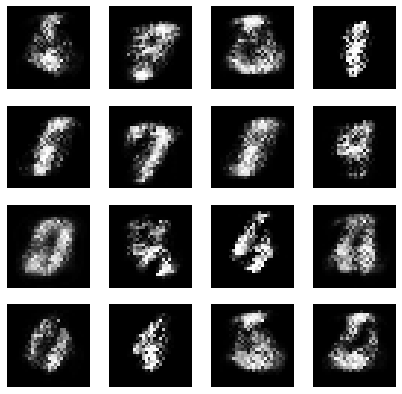

Epoch: 20 | Generator Loss: 1.00869 | Discirminator Loss: 1.35304 | Classifier Loss: 0.00003


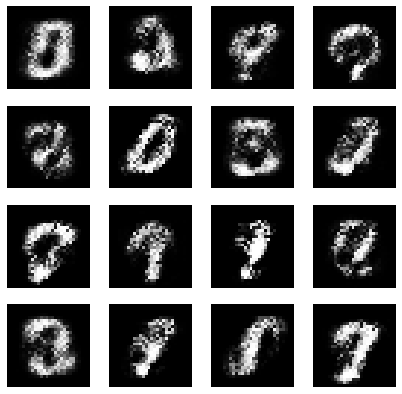

Epoch: 21 | Generator Loss: 0.98748 | Discirminator Loss: 1.32107 | Classifier Loss: 0.00003


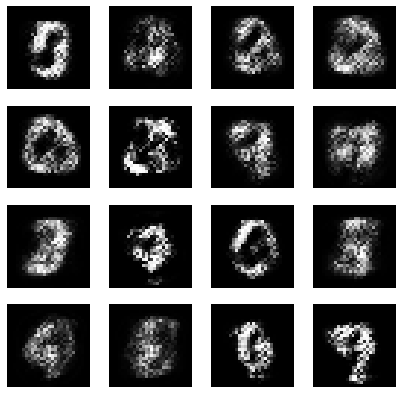

Epoch: 22 | Generator Loss: 0.98900 | Discirminator Loss: 1.33260 | Classifier Loss: 0.00002


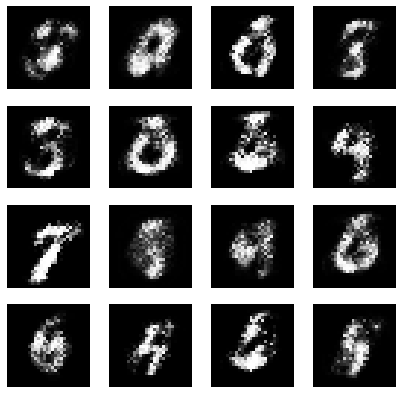

Epoch: 23 | Generator Loss: 0.94999 | Discirminator Loss: 1.38717 | Classifier Loss: 0.00001


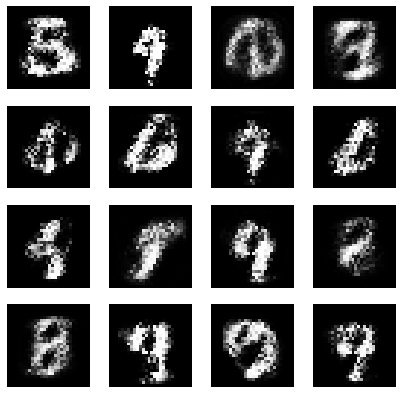

Epoch: 24 | Generator Loss: 1.01568 | Discirminator Loss: 1.35511 | Classifier Loss: 0.00001


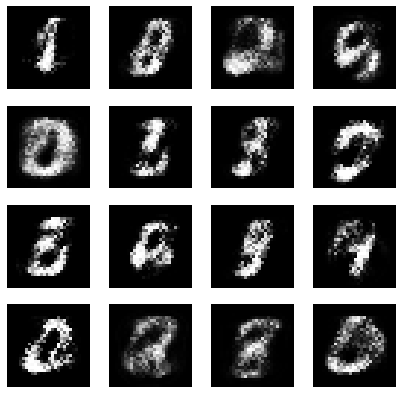

Epoch: 25 | Generator Loss: 0.93379 | Discirminator Loss: 1.34056 | Classifier Loss: 0.00002


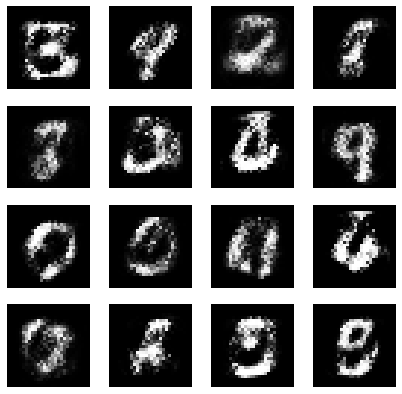

Epoch: 26 | Generator Loss: 0.92674 | Discirminator Loss: 1.35166 | Classifier Loss: 0.00002


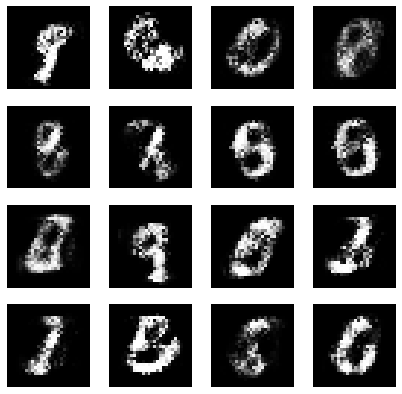

Epoch: 27 | Generator Loss: 0.92224 | Discirminator Loss: 1.31114 | Classifier Loss: 0.00002


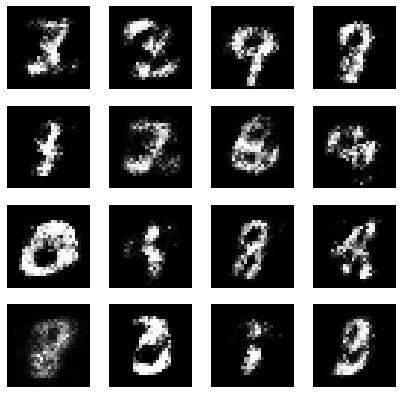

Epoch: 28 | Generator Loss: 0.93882 | Discirminator Loss: 1.30226 | Classifier Loss: 0.00002


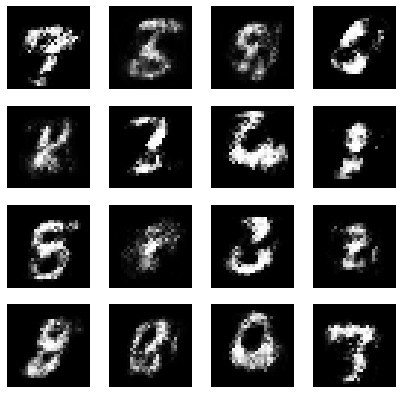

Epoch: 29 | Generator Loss: 0.93149 | Discirminator Loss: 1.29171 | Classifier Loss: 0.00002


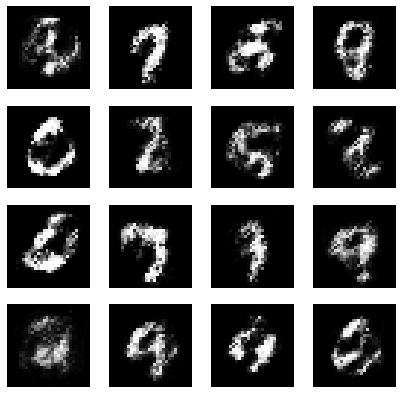

Epoch: 30 | Generator Loss: 0.94908 | Discirminator Loss: 1.28692 | Classifier Loss: 0.00002


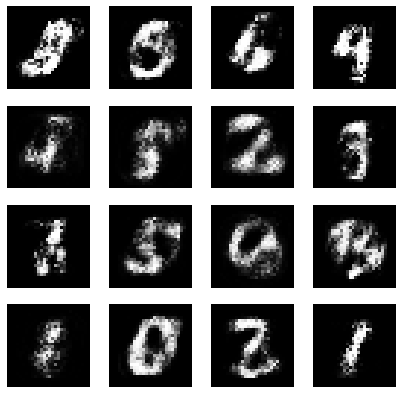

Epoch: 31 | Generator Loss: 0.91869 | Discirminator Loss: 1.29660 | Classifier Loss: 0.00002


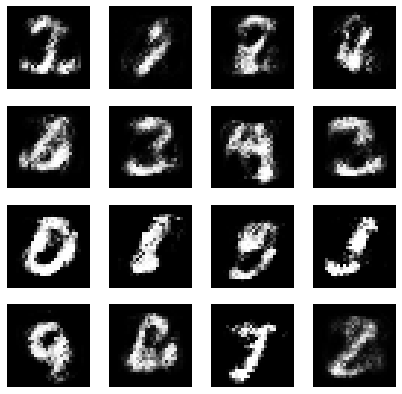

Epoch: 32 | Generator Loss: 0.90315 | Discirminator Loss: 1.29864 | Classifier Loss: 0.00002


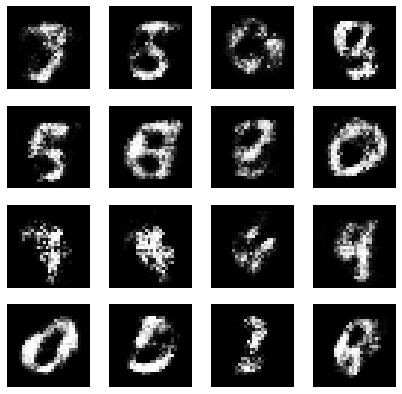

Epoch: 33 | Generator Loss: 0.94512 | Discirminator Loss: 1.30114 | Classifier Loss: 0.00002


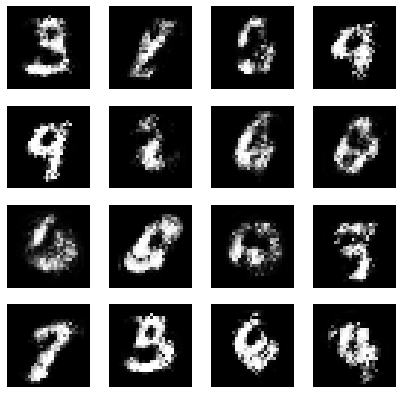

Epoch: 34 | Generator Loss: 0.92413 | Discirminator Loss: 1.29718 | Classifier Loss: 0.00001


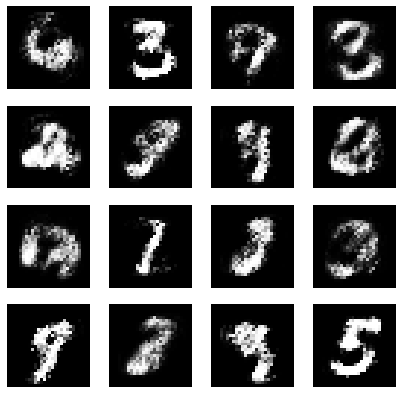

Epoch: 35 | Generator Loss: 0.91639 | Discirminator Loss: 1.29114 | Classifier Loss: 0.00001


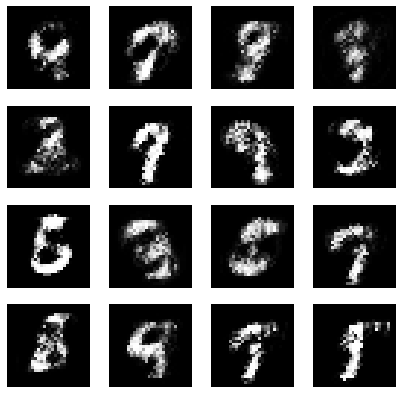

Epoch: 36 | Generator Loss: 0.92321 | Discirminator Loss: 1.29847 | Classifier Loss: 0.00001


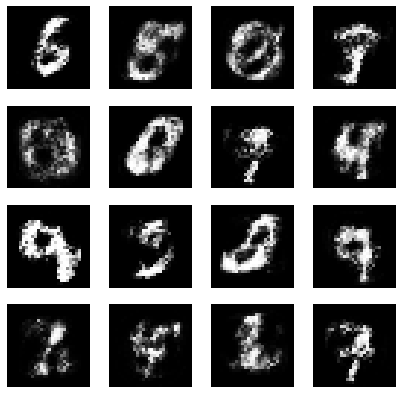

Epoch: 37 | Generator Loss: 0.91467 | Discirminator Loss: 1.29740 | Classifier Loss: 0.00001


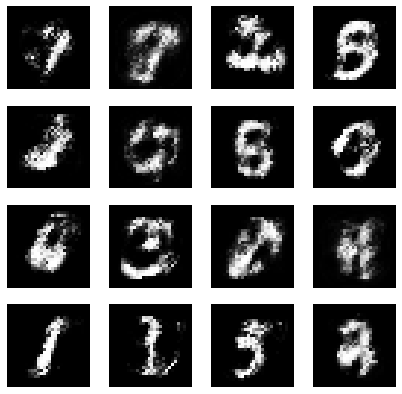

Epoch: 38 | Generator Loss: 0.90174 | Discirminator Loss: 1.31758 | Classifier Loss: 0.00001


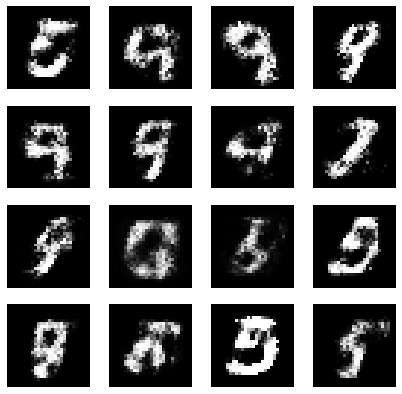

Epoch: 39 | Generator Loss: 0.89934 | Discirminator Loss: 1.29406 | Classifier Loss: 0.00001


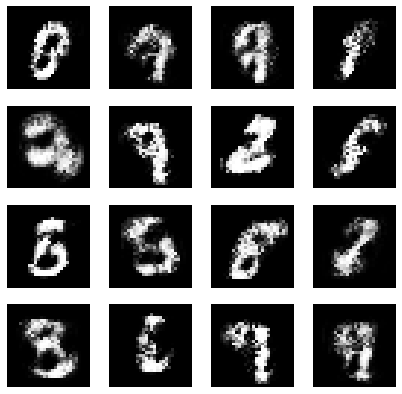

Epoch: 40 | Generator Loss: 0.95948 | Discirminator Loss: 1.30036 | Classifier Loss: 0.00001


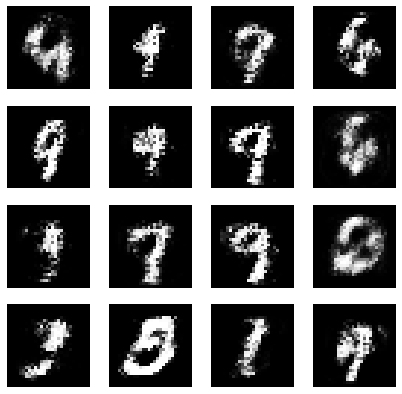

Epoch: 41 | Generator Loss: 0.88668 | Discirminator Loss: 1.31384 | Classifier Loss: 0.00001


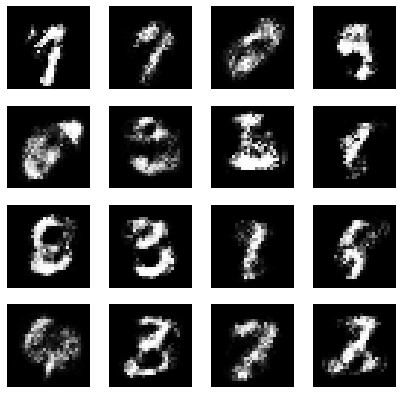

Epoch: 42 | Generator Loss: 0.88234 | Discirminator Loss: 1.28251 | Classifier Loss: 0.00001


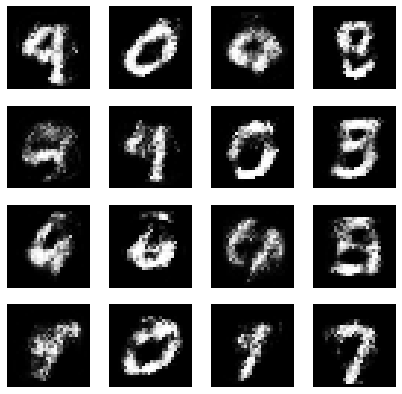

Epoch: 43 | Generator Loss: 0.89038 | Discirminator Loss: 1.28068 | Classifier Loss: 0.00001


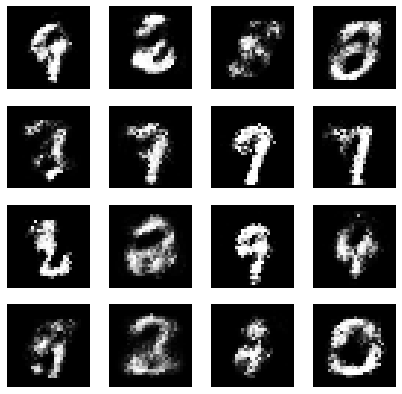

Epoch: 44 | Generator Loss: 0.90609 | Discirminator Loss: 1.26099 | Classifier Loss: 0.00001


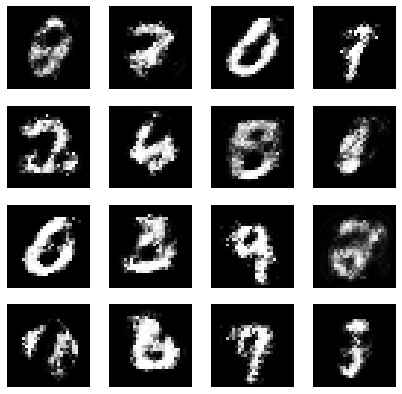

Epoch: 45 | Generator Loss: 0.89711 | Discirminator Loss: 1.27513 | Classifier Loss: 0.00001


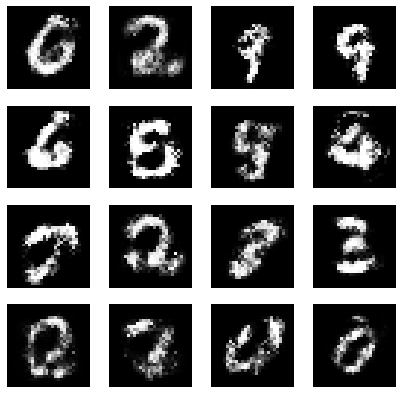

Epoch: 46 | Generator Loss: 0.89730 | Discirminator Loss: 1.27161 | Classifier Loss: 0.00001


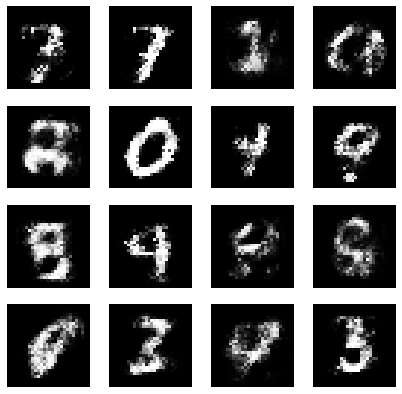

Epoch: 47 | Generator Loss: 0.91351 | Discirminator Loss: 1.28011 | Classifier Loss: 0.00001


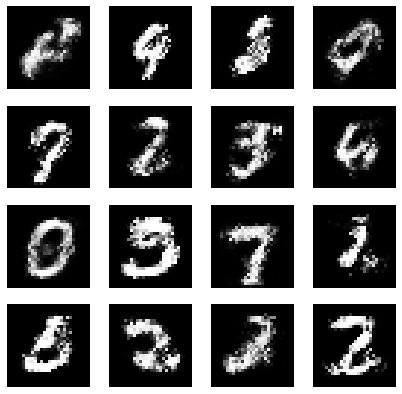

Epoch: 48 | Generator Loss: 0.89653 | Discirminator Loss: 1.29270 | Classifier Loss: 0.00001


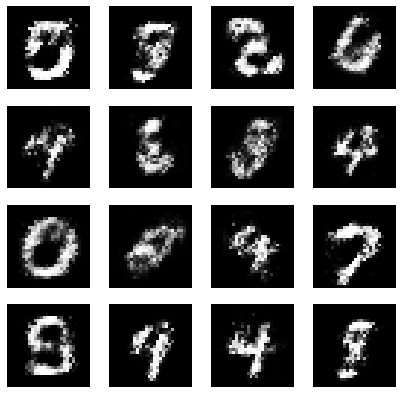

Epoch: 49 | Generator Loss: 0.87933 | Discirminator Loss: 1.27982 | Classifier Loss: 0.00001


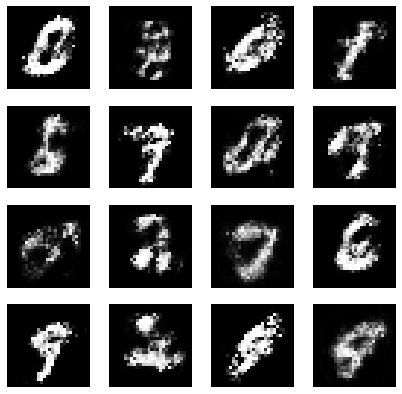

In [35]:
epochs = 50 # a gan usually takes a lot of epochs to work properly
num_batches = 60000//batch_size
learning_rate = 0.001

Glosses = []
Dlosses = []
Closses = []

t = 0
for epoch in range(epochs):
    gcum_loss = 0.0
    dcum_loss = 0.0
    ccum_loss = 0.0
    for features, _ in training_data:
        # "features, _" because "_" are the labels of the features returned by training data loader,
        # which we don't need any more since we since we are going unsupervised generation of data, not classification
        t += 1
        features = features.as_in_context(ctx)
        labels = nd.random.randint(0, 10, features.shape[0]).one_hot(10).as_in_context(ctx)
        z = nd.random.normal(0, 1, (features.shape[0], 100)).as_in_context(ctx)

        with autograd.record():
            generated = generator(z, labels)
            false = discriminator(generated)
            true = discriminator(features)
            Dloss = dloss(true, false)
        Dloss.backward()
        adam(t, dparams, vs = dvs, sqrs = dsqrs, lr = learning_rate)

        with autograd.record():
            generated = generator(z, labels)
            false = discriminator(generated)
            Gloss = gloss(false)
        Gloss.backward()
        adam(t, gparams, vs = gvs, sqrs = gsqrs, lr = learning_rate)

        with autograd.record():
            generated = generator(z, labels)
            outputs = classifier(generated)
            Closs = closs(outputs, labels)
        Closs.backward()
        adam(t, cparams, vs = cvs, sqrs = csqrs, lr = learning_rate)
        adam(t, gparams, vs = gvs, sqrs = gsqrs, lr = learning_rate)
        
        gcum_loss += Gloss
        dcum_loss += Dloss
        ccum_loss += Closs
    
    Gloss = gcum_loss.asscalar()/num_batches
    Dloss = dcum_loss.asscalar()/num_batches
    Closs = ccum_loss.asscalar()/num_batches
    
    Glosses.append(Gloss)
    Dlosses.append(Dloss)
    Closses.append(Closs)
    
    print(f'Epoch: {epoch} | Generator Loss: {Gloss:.5f} | Discirminator Loss: {Dloss:.5f} | Classifier Loss: {Closs:.5f}')
    
    plt.figure(figsize = (7, 7))
    for i, image in enumerate(generated[:16], 1):
        plt.subplot(4, 4, i)
        plt.imshow(image.reshape((28, 28)).asnumpy(), cmap = 'gray')
        plt.axis('off')
    plt.show()

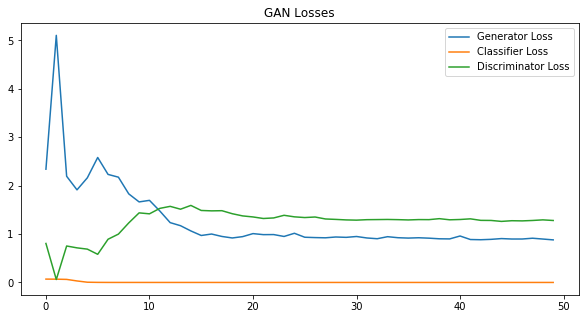

In [37]:
plt.figure(figsize = (10, 5))
plt.plot(Glosses, label = 'Generator Loss')
plt.plot(Closses, label = 'Classifier Loss')
plt.plot(Dlosses, label = 'Discriminator Loss')
plt.legend()
plt.title('GAN Losses')
plt.show()

So now we can simply play with the code relations that our models have learned to have more control on generator

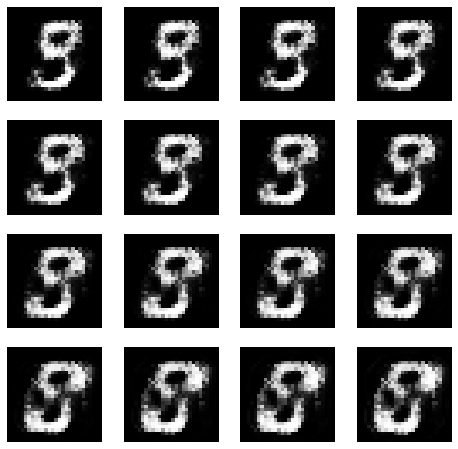


[[0. 0. 0. 0. 4. 0. 0. 0. 0. 0.]]
<NDArray 1x10 @gpu(0)>

In [126]:
noise = nd.random.normal(0, 1, (1, 100)).as_in_context(ctx)
codes = nd.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).as_in_context(ctx)

plt.figure(figsize = (8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    codes[0][4] += 1.0/4.0
    image = generator(noise, codes)[0]
    plt.imshow(image.reshape((28, 28)).asnumpy(), 'gray')
    plt.axis('off')
plt.show()

codes